In [1]:
# import libraries

import pandas as pd
import numpy as np
import requests

In [2]:
# pull hdb resale transactions from data.gov.sg
url = 'https://data.gov.sg/api/action/datastore_search?resource_id=f1765b54-a209-4718-8d38-a39237f502b3'
response = requests.get(url)
data = response.json()

In [3]:
# search params
search_params = {'limit': 0}
# get total number of records from website
total_records = data['result']['total']
search_params['limit'] = total_records
# retrieve all records from url
response = requests.get(url, params=search_params)
data = response.json()

In [4]:
# convert data to dataframe
df = pd.DataFrame(data['result']['records'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157681 entries, 0 to 157680
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   town                 157681 non-null  object
 1   flat_type            157681 non-null  object
 2   flat_model           157681 non-null  object
 3   floor_area_sqm       157681 non-null  object
 4   street_name          157681 non-null  object
 5   resale_price         157681 non-null  object
 6   month                157681 non-null  object
 7   remaining_lease      157681 non-null  object
 8   lease_commence_date  157681 non-null  object
 9   storey_range         157681 non-null  object
 10  _id                  157681 non-null  int64 
 11  block                157681 non-null  object
dtypes: int64(1), object(11)
memory usage: 14.4+ MB


In [6]:
df.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,remaining_lease,lease_commence_date,storey_range,_id,block
0,ANG MO KIO,2 ROOM,Improved,44,ANG MO KIO AVE 10,232000,2017-01,61 years 04 months,1979,10 TO 12,1,406
1,ANG MO KIO,3 ROOM,New Generation,67,ANG MO KIO AVE 4,250000,2017-01,60 years 07 months,1978,01 TO 03,2,108
2,ANG MO KIO,3 ROOM,New Generation,67,ANG MO KIO AVE 5,262000,2017-01,62 years 05 months,1980,01 TO 03,3,602
3,ANG MO KIO,3 ROOM,New Generation,68,ANG MO KIO AVE 10,265000,2017-01,62 years 01 month,1980,04 TO 06,4,465
4,ANG MO KIO,3 ROOM,New Generation,67,ANG MO KIO AVE 5,265000,2017-01,62 years 05 months,1980,01 TO 03,5,601


In [7]:
## convert resale_price to integer
df['resale_price'] = df['resale_price'].astype('float')

In [8]:
df['town'].unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT MERAH', 'BUKIT BATOK',
       'CENTRAL AREA', 'BUKIT PANJANG', 'GEYLANG', 'BUKIT TIMAH',
       'CHOA CHU KANG', 'CLEMENTI', 'PUNGGOL', 'HOUGANG', 'QUEENSTOWN',
       'JURONG EAST', 'JURONG WEST', 'KALLANG/WHAMPOA', 'MARINE PARADE',
       'PASIR RIS', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
       'TOA PAYOH', 'WOODLANDS', 'YISHUN'], dtype=object)

In [9]:
""" 
Classify Ang Mo Kio, Bedok, Bishan, Bukit Merah, Bukit Timah, Central, Clementi, Geylang, Kallang/Whampoa, Marine Parade, Pasir Ris, Queenstown, Serangoon, Tampines, Toa Payoh as Mature Estates

Classify Bukit Batok, Bukit Panjang, Choa Chu Kang, Hougang, Jurong, Punggol, Sembawang, Sengkang, Tengah, Woodlands, Yishun to be classified as Non-Matured Estates
"""

mature_estates = ['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT MERAH', 'BUKIT TIMAH', 'CENTRAL AREA', 'CLEMENTI', 'GEYLANG', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'QUEENSTOWN', 'SERANGOON', 'TAMPINES', 'TOA PAYOH']
non_mature_estates = ['BUKIT BATOK', 'BUKIT PANJANG', 'CHOA CHU KANG', 'HOUGANG', 'JURONG', 'PUNGGOL', 'SEMBAWANG', 'SENGKANG', 'TENGAH', 'WOODLANDS', 'YISHUN']

# create new column to classify mature and non-mature estates
df['Estate Type'] = np.where(df['town'].isin(mature_estates), 'Matured Estate', 'Non-Matured Estate')

In [10]:
# convert month column to datetime
df['sale_period'] = pd.to_datetime(df['month'])

# split remaining_lease into years and months
df['remaining_lease_years'] = df['remaining_lease'].str[:2]
df['remaining_lease_months'] = df['remaining_lease'].str[9:11]


In [11]:
# # reshuffle columns
df = df[['town',
         'Estate Type',
         'flat_type', 
         'flat_model', 
         'floor_area_sqm',
         'block',
         'street_name',
         'resale_price',
         'sale_period',
         'remaining_lease_years',
         'remaining_lease_months',
         'storey_range']]

In [12]:
# filter year column from 2017 onwards
df_filtered = df[df['sale_period'].dt.year >= 2017]

# filter out selected flat_models
flat_filters = ['EXECUTIVE']
town_filters = ['PUNGGOL','SENGKANG']
# street_filters = ['PUNGGOL CTRL']
df_filtered = df_filtered[df_filtered['flat_type'].isin(flat_filters) & df_filtered['town'].isin(town_filters)]


In [13]:
# sort by resale_price in descending order
df_filtered.sort_values(by='resale_price', ascending=False, inplace=True)

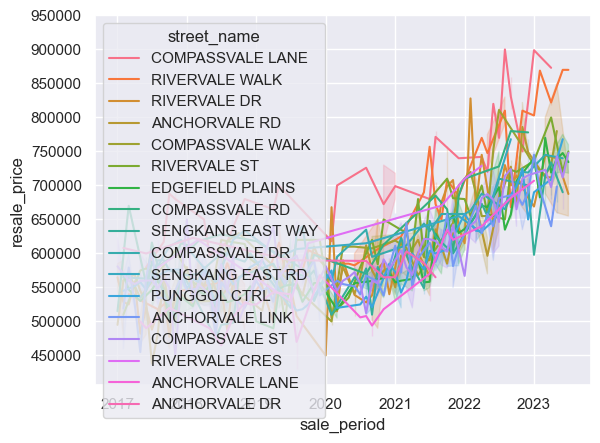

In [14]:
# plot resale_price vs sale_period with street_name as hue
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# plot resale_price vs sale_period with street_name as hue  
sns.lineplot(x='sale_period', y='resale_price', hue='street_name', data=df_filtered)
plt.yticks(np.arange(450000,1000000,50000))
plt.show()


